# 时间序列预测
这包括两个主要部分

1. 单个时间步长的预测：

  * 所有功能。
  * 一个单一的功能。


2. 预测多个步骤：
    * Single-shot：一次性做出所有预测。
    * 自回归：一次做一个预测并将输出反馈给模型。




In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

本教程使用马克斯普朗克生物地球化学研究所记录的天气时间序列数据集。
数据集包含 14 个不同的特征，例如气温、大气压力和湿度。从 2003 年开始，每 10 分钟收集一次。为了提高效率，您将仅使用 2009 年至 2016 年期间收集的数据

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13582336/13568290 [==============================] - 0s 0us/step


本教程将只处理每小时预测，因此首先从 10 分钟间隔到 1 小时间隔对数据进行二次抽样：

In [3]:
df = pd.read_csv(csv_path)
# slice[start:stop:step]从索引5开始，步长为6
df = df[5::6]
date_time = pd.to_datetime(df.pop('Date Time'),format='%d.%m.%Y %H:%M:%S')

In [4]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


可视化一个属性随着时间变化的规律

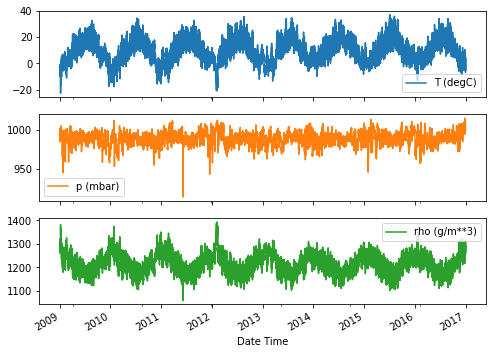

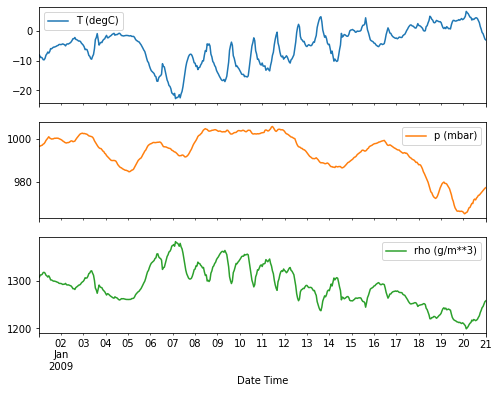

In [5]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

检查和清理

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


# 数据清洗
应该突出的一件事是min风速 ( wv (m/s)) 和最大值 ( max. wv (m/s)) 列的值。这-9999很可能是错误的。

有一个单独的风向列，所以速度应该大于零（>=0）。用零替换它：

In [7]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

# 特征工程
1. 风
2. 时间


Text(0, 0.5, 'Wind Velocity [m/s]')

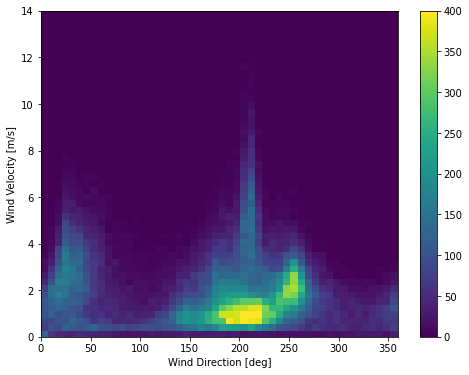

In [8]:
# 风
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

将风向和速度列转换为风矢量

In [9]:

wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')
#转换为弧度
# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180
# 计算风的x，y风组件
# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)
# #计算最大风x和y分量。
# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

模型 风矢量分布

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

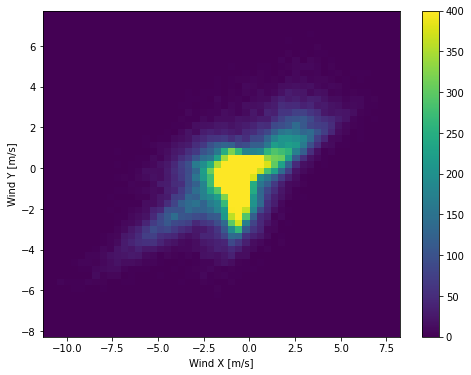

In [10]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [11]:
# 时间
# 但不是这种字符串形式。首先将其转换为秒：
timestamp_s = date_time.map(pd.Timestamp.timestamp)


与风向类似，以秒为单位的时间不是有用的模型输入。作为气象数据，具有明确的日、年周期性。有很多方法可以处理周期性。

您可以通过使用正弦和余弦变换来清除“一天中的时间”和“一年中的时间”信号来获得可用的信号：

In [12]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

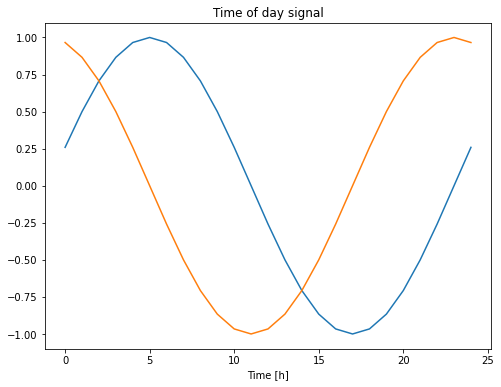

In [13]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

通过使用Fast Fourier Transform提取特征来确定哪些频率很重要。为了检查假设，这里是tf.signal.rfft温度随时间的变化。1/year注意和附近频率处的明显峰值1/day：



In [14]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0,len(fft))

In [15]:
n_samples_h = len(df['T (degC)'])
hours_per_year = 24*265.2534
years_per_dataset = n_samples_h/(hours_per_year)
f_per_year = f_per_dataset/years_per_dataset

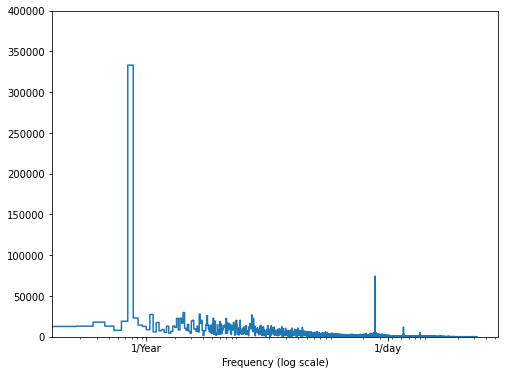

In [16]:
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

# 拆分数据
您将对(70%, 20%, 10%)训练、验证和测试集使用拆分。请注意，数据在拆分之前不会被随机打乱。这有两个原因：

1. 它确保将数据切割成连续样本的窗口仍然是可能的。
2. 它确保验证/测试结果更加真实，并根据模型训练后收集的数据进行评估。

In [17]:
column_indices = {name:i for i ,name in enumerate(df.columns)}
n = len(df)

train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]
num_features = df.shape[1]

# 规划化数据
在训练神经网络之前缩放特征很重要。归一化是进行这种缩放的常用方法：减去均值并除以每个特征的标准差。





均值和标准差只能使用训练数据来计算，这样模型就无法访问验证集和测试集中的值。

In [18]:
train_mean = train_df.mean()
train_std = train_df.std()

In [19]:
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

现在，看看特征的分布。有些特征确实有长尾，但没有像-9999风速值这样的明显误差。



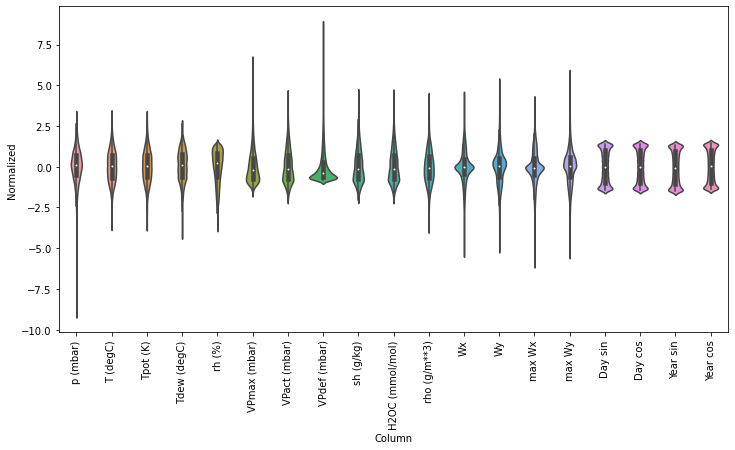

In [20]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

# 数据窗口
输入窗口的主要特点是：
*   输入和标签窗口的宽度（时间步数）。
*   它们之间的时间偏移。
*   哪些特征用作输入、标签或两者兼而有之。




本节的其余部分定义了一个WindowGenerator类。这个类可以：

1. 如上图所示处理索引和偏移量。
2. 将特征窗口分成(features, labels)对。
3. 绘制结果窗口的内容。
4. tf.data.Dataset使用s.从训练、评估和测试数据中高效地生成这些窗口的批次。

In [21]:
#数据窗口-索引和偏移量
class WindowGenerator():
  def __init__(self,input_width,label_width,shift,train_df=train_df,val_df=val_df,
               test_df = test_df,label_columns=None):
    # 存储初始数据
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    
    #计算标签列索引
    self.label_columns = label_columns

    if label_columns is not None:
      self.label_columns_indices = {name:i for i,name in enumerate(label_columns)} 
    self.column_indices = {name:i for i,name in enumerate(train_df.columns)}

    # 计算窗口的参数
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0,input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start,None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return  '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [22]:
# 对未来24小时预测，基于过去24小时记录
w1 = WindowGenerator(input_width=24,label_width=1,shift=24,label_columns=[''])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['']

In [23]:
# 对未来1小时预测，基于过去6小时记录
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

In [24]:
# 数据窗口-拆分
def split_window(self,features):
  inputs = features[:,self.input_slice,:]
  labels = features[:,self.labels_slice,:]

  if self.label_columns is not None:
    labels = tf.stack([labels[:,:,self.column_indices[name]] for name in self.label_columns],axis=-1)
  #切片不保留静态形状信息，因此手动设置形状
  #通过这种方式，tf.data。数据集更易于检查。
  inputs.set_shape([None,self.input_width,None])
  labels.set_shape([None,self.label_width,None])

  return inputs,labels
WindowGenerator.split_window = split_window

In [25]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


In [26]:
# 数据窗口-绘图
w2.example = example_inputs, example_labels

In [27]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

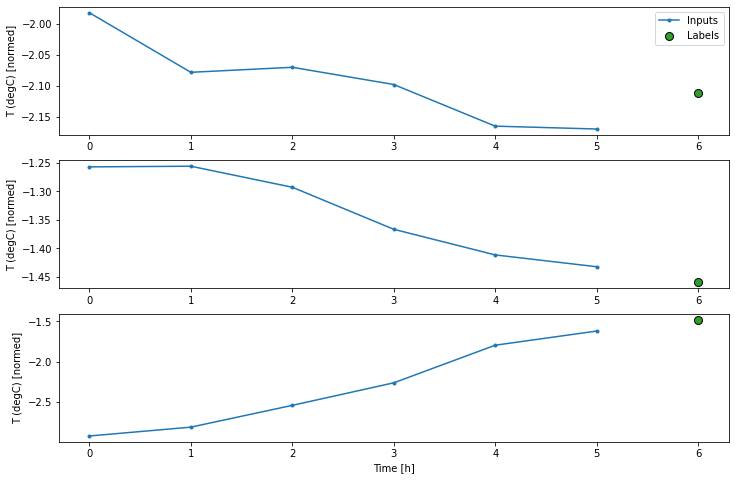

In [28]:
w2.plot()

绘制其他列，但是windoww2配置只有t(degc)标签

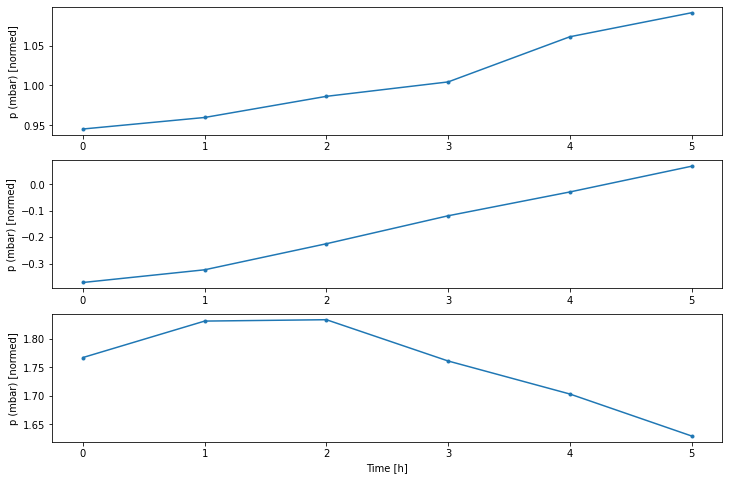

In [29]:
w2.plot(plot_col='p (mbar)')

最后，此make_dataset方法将采用时间序列 DataFrame 并使用以下函数将其转换为一tf.data.Dataset对：(input_window, label_window)tf.keras.utils.timeseries_dataset_from_array

In [31]:
# 数据窗口-创建数据集
def make_dataset(self,data):
  data = np.array(data,dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length = self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32
  )
  ds = ds.map(self.split_window)
  return ds 
WindowGenerator.make_dataset = make_dataset

使用您之前定义的方法添加属性以将它们作为tf.data.Datasets访问。make_dataset此外，添加一个标准示例批次以便于访问和绘图：

In [32]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  result = getattr(self,'_example_',None)
  if result is None:
    # 没有实例批次，从训练集合拿一点
    result = next(iter(self.train))
    self._example = result
  return result 
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example



现在，该WindowGenerator对象使您可以访问tf.data.Dataset对象，因此您可以轻松地迭代数据。

该Dataset.element_spec属性告诉您数据集元素的结构、数据类型和形状。

In [33]:
# 每个元素包含一个（输入，类别）
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

迭代a数据集产生具体批次

In [34]:
for example_inputs,example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


# 单步模型
您可以在此类数据上构建的最简单模型是仅根据当前条件预测单个特征值的模型——未来 1 个时间步长（一小时）。

因此，首先要建立模型来预测T (degC)未来一小时的价值。

In [35]:
# 配置一个WindowGenerator对象以产生单步（input,label）对
single_step_window = WindowGenerator(
    input_width=1,label_width=1,shift=1,
    label_columns =['T (degC)']
)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

In [36]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


# 单步模型-基线
在构建可训练模型之前，最好有一个<u>性能基线</u>作为与后来更复杂的模型进行比较的点。

第一个任务是在给定所有特征的当前值的情况下预测未来一小时的温度。当前值包括当前温度。

因此，从一个仅返回当前温度作为预测的模型开始，**预测“没有变化”。这是一个合理的基线**，因为温度变化缓慢。当然，如果你在未来做进一步的预测，这个基线会不太好。

In [37]:
class Baseline(tf.keras.Model):
  def __init__(self,label_index=None):
    super().__init__()
    self.label_index=label_index
  def call(self,inputs):
    if self.label_index is None:
      return inputs 
    result = inputs[:,:,self.label_index]
    return result[:,:,tf.newaxis]


In [54]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 2s 5ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


创建一个更宽WindowGenerator的，一次生成 24 小时连续输入和标签的窗口。新wide_window变量不会改变模型的运行方式。该模型仍然基于单个输入时间步长对未来一小时进行预测。在这里，time轴就像batch轴一样：每个预测都是独立进行的，时间步长之间没有交互：

In [55]:
wide_window = WindowGenerator(
    input_width=24,label_width=24,shift=1,
    label_columns=['T (degC)']
)
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

In [56]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


通过绘制基线模型的预测，只需把标签右移一小时

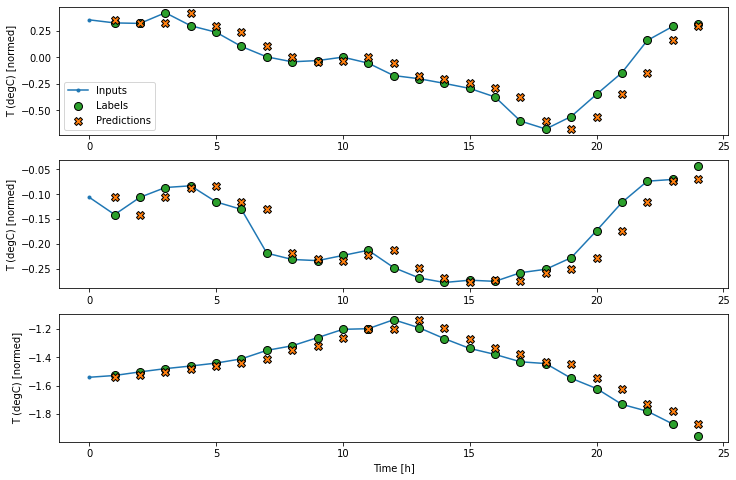

In [57]:
wide_window.plot(baseline)

# 单步模型-线性模型
您可以应用于此任务的最简单的可训练模型是在输入和输出之间插入线性变换。在这种情况下，时间步的输出仅取决于该步：

In [58]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


将训练过程打包成一个函数

In [59]:
MAX_EPOCHS = 20

def compile_and_fit(model,window,patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience,mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])
  
  history = model.fit(window.train,epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])

  return history

In [60]:
# 训练模型并评估性能
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 10s 6ms/step - loss: 0.0941 - mean_absolute_error: 0.1785 - val_loss: 0.0110 - val_mean_absolute_error: 0.0771
Epoch 2/20
1534/1534 [==============================] - 11s 7ms/step - loss: 0.0103 - mean_absolute_error: 0.0751 - val_loss: 0.0093 - val_mean_absolute_error: 0.0707
Epoch 3/20
1534/1534 [==============================] - 8s 5ms/step - loss: 0.0094 - mean_absolute_error: 0.0712 - val_loss: 0.0088 - val_mean_absolute_error: 0.0685
Epoch 4/20
1534/1534 [==============================] - 10s 7ms/step - loss: 0.0091 - mean_absolute_error: 0.0699 - val_loss: 0.0087 - val_mean_absolute_error: 0.0681
Epoch 5/20
1534/1534 [==============================] - 11s 7ms/step - loss: 0.0091 - mean_absolute_error: 0.0697 - val_loss: 0.0087 - val_mean_absolute_error: 0.0681
Epoch 6/20
1534/1534 [==============================] - 15s 10ms/step - loss: 0.0091 - mean_absolute_error: 0.0696 - val_loss: 0.0087 - val_mean_absolute_error: 0.068

与baseline模型一样，线性模型可以在批量宽窗口上调用。使用这种方式，模型会对连续的时间步长进行一组独立的预测。该time轴的作用类似于另一个batch轴。每个时间步的预测之间没有相互作用。



In [61]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


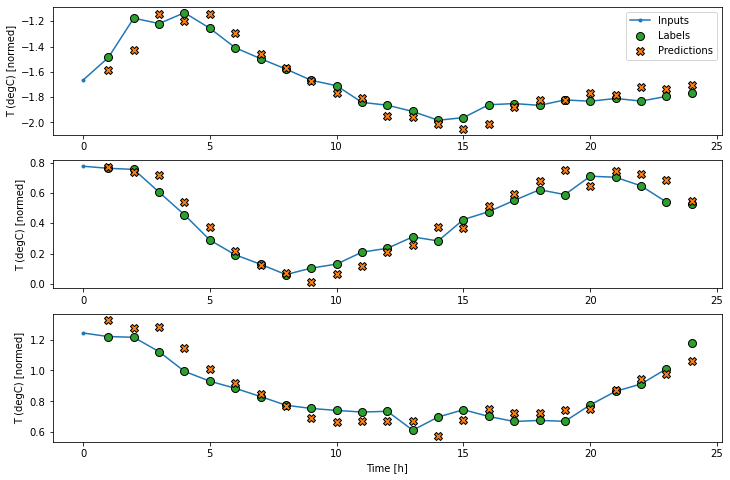

In [62]:
wide_window.plot(linear)

线性模型的一个优点是相对容易解释，可以提取层的权重可视化分配每个输入的权重

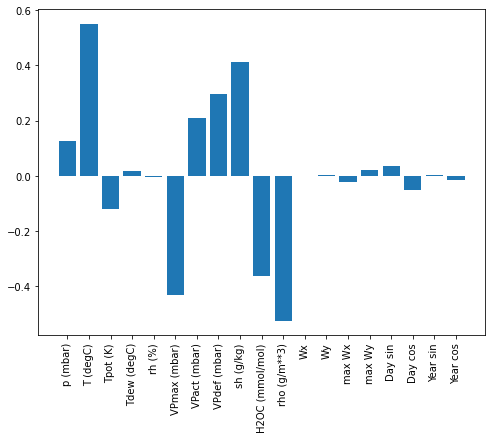

In [63]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

# 单步模型-稠密

在应用实际在多个时间步上运行的模型之前，有必要检查更深入、更强大的单输入步模型的性能。

这是一个类似于模型的模型，除了它在输入和输出之间linear堆叠了几层：Dense

In [65]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64,activation='relu'),
    tf.keras.layers.Dense(units=64,activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense,single_step_window)

Epoch 1/20
1534/1534 [==============================] - 14s 8ms/step - loss: 0.0190 - mean_absolute_error: 0.0823 - val_loss: 0.0079 - val_mean_absolute_error: 0.0652
Epoch 2/20
1534/1534 [==============================] - 10s 6ms/step - loss: 0.0078 - mean_absolute_error: 0.0643 - val_loss: 0.0107 - val_mean_absolute_error: 0.0751
Epoch 3/20
1534/1534 [==============================] - 10s 6ms/step - loss: 0.0074 - mean_absolute_error: 0.0618 - val_loss: 0.0100 - val_mean_absolute_error: 0.0735


In [66]:
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test,verbose=0)

439/439 [==============================] - 2s 5ms/step - loss: 0.0100 - mean_absolute_error: 0.0735


# 单步密集-多步密集

单时间步模型没有关于其输入的当前值的上下文。它看不到输入特征如何随时间变化。为了解决这个问题，模型在进行预测时需要访问多个时间步：

In [67]:
CONV_WIDTH=3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)']
)
conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

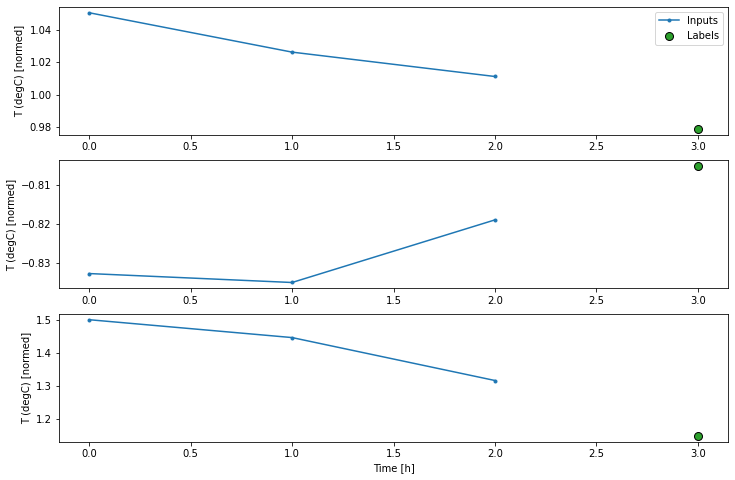

In [68]:
conv_window.plot()

您可以通过添加 a作为模型的第一层，在dense多输入步骤窗口上训练模型：tf.keras.layers.Flatten



In [69]:
multi_step_dense = tf.keras.Sequential([
    # shape(time,features)=>(time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32,activation='relu'),
    tf.keras.layers.Dense(units=32,activation='relu'),
    tf.keras.layers.Dense(units=1),
    # 添加时间维度
    # shape(outputs)=>(1,outputs)
    tf.keras.layers.Reshape([1,-1]),
])

In [70]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [71]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

438/438 [==============================] - 2s 4ms/step - loss: 0.0071 - mean_absolute_error: 0.0606


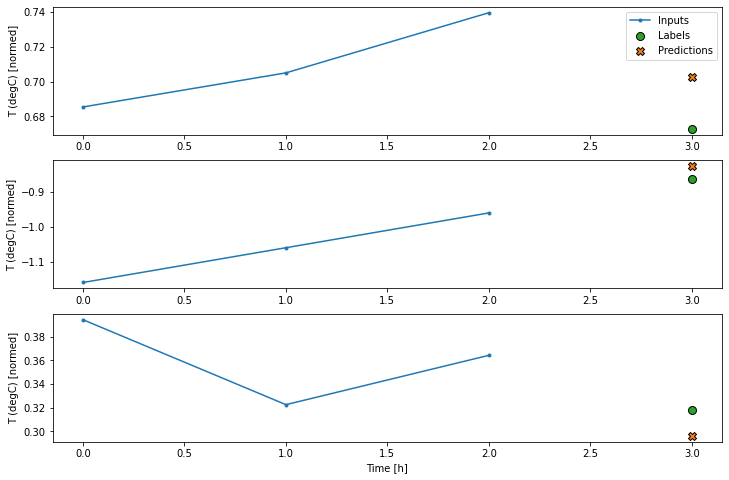

In [72]:
conv_window.plot(multi_step_dense)

In [73]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 19)

ValueError:Exception encountered when calling layer "sequential_5" (type Sequential).

Input 0 of layer "dense_11" is incompatible with the layer: expected axis -1 of input shape to have value 57, but received input with shape (32, 456)

Call arguments received:
  • inputs=tf.Tensor(shape=(32, 24, 19), dtype=float32)
  • training=None
  • mask=None


# 单步模型-卷积神经网络
卷积层 (· tf.keras.layers.Conv1D) 还需要多个时间步长作为每个预测的输入。
下面是与相同的模型multi_step_dense，用卷积重写。

注意变化：

1. tf.keras.layers.Flatten和第一个被tf.keras.layers.Dense替换为tf.keras.layers.Conv1D。
2. tf.keras.layers.Reshape不再需要，因为卷积将时间轴保留在其输出中。

In [74]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,kernel_size=(CONV_WIDTH),activation='relu'),
    tf.keras.layers.Dense(units=32,activation='relu'),
    tf.keras.layers.Dense(units=1)
])

在示例批次上运行它以检查模型是否产生预期形状的输出

In [75]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


对其进行训练和评估conv_window，它应该提供与模型相似的性能multi_step_dense。



In [76]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

438/438 [==============================] - 2s 5ms/step - loss: 0.0070 - mean_absolute_error: 0.0602


conv_model这和multi_step_dense模型之间的区别在于conv_model可以在任何长度的输入上运行。卷积层应用于输入的滑动窗口：



In [77]:
# 如果在更宽的输入上运行，产生更宽的输出
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


请注意，输出比输入短。要使训练或绘图工作，您需要标签和预测具有相同的长度。因此，构建一个WindowGenerator以产生具有一些额外输入时间步长的宽窗口，以便标签和预测长度匹配：



In [78]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH+(CONV_WIDTH -1 )

wide_conv_window = WindowGenerator(
    input_width = INPUT_WIDTH,
    label_width = LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)']
)
wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [79]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


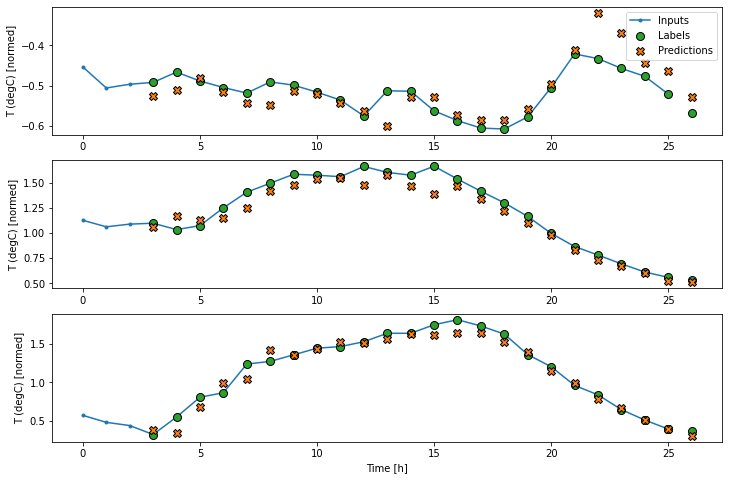

In [80]:
wide_conv_window.plot(conv_model)

# 单步模型-递归神经网络
循环神经网络 (RNN) 是一种非常适合时间序列数据的神经网络。RNN 逐步处理时间序列，从时间步到时间步保持内部状态。
您将使用名为 Long Short-Term Memory ( tf.keras.layers.LSTM) 的 RNN 层。

所有 Keras RNN 层的一个重要构造函数参数，例如tf.keras.layers.LSTM，是return_sequences参数。此设置可以通过以下两种方式之一配置层：
1. 如果False，默认情况下，该层仅返回最后时间步的输出，给模型时间来预热其内部状态，然后再进行单个预测：
<img src='https://www.tensorflow.org/static/tutorials/structured_data/images/lstm_1_window.png'>



2. 如果True，则该层为每个输入返回一个输出。这对于
*   同时在多个时间步上训练模型。
*   堆叠 RNN 层。



<img src='https://www.tensorflow.org/static/tutorials/structured_data/images/lstm_many_window.png'>






In [82]:
lstm_model = tf.keras.models.Sequential([
    # shape(batch,time,features)=>[batch,time,lstm_units]
    tf.keras.layers.LSTM(32,return_sequences=True),
    # shape=>[batch,time,features]
    tf.keras.layers.Dense(units=1)
])

In [83]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


In [84]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 3s 8ms/step - loss: 0.0055 - mean_absolute_error: 0.0509


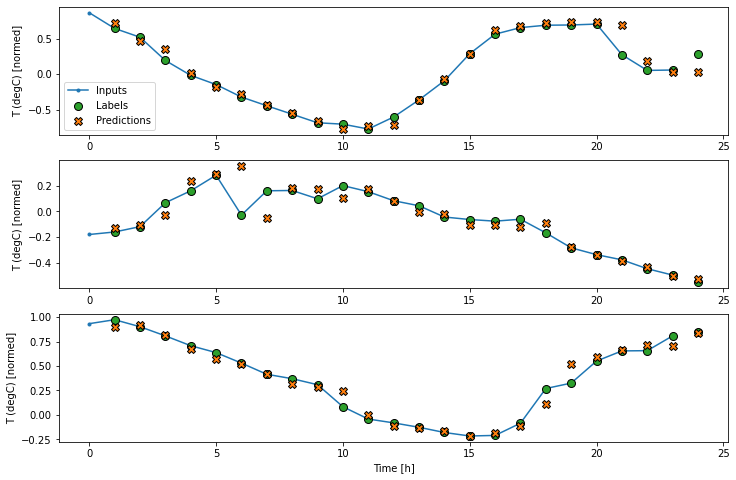

In [85]:
wide_window.plot(lstm_model)

# 单步模型-各个模型的表现

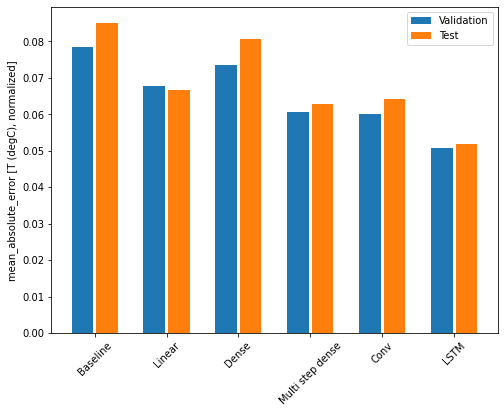

In [86]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [88]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0667
Dense       : 0.0807
Multi step dense: 0.0630
Conv        : 0.0642
LSTM        : 0.0520


# 单步模型-多数出型号

到目前为止，所有模型都预测了T (degC)单个时间步长的单个输出特征 。

所有这些模型都可以转换为预测多个特征，只需更改输出层中的单元数并调整训练窗口以包含labels( example_labels) 中的所有特征：


In [89]:
single_step_window = WindowGenerator(
    # WindowGenerator 中不设置label_columns即可返回所有特征
    input_width=1,label_width=1,shift=1
)

wide_window = WindowGenerator(
    input_width=24,label_width=24,shift=1
)

for example_inputs,example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


此处可使用相同的基线模型。但这次重复所有特征而不是选择特定的label

In [91]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [92]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 2s 5ms/step - loss: 0.0886 - mean_absolute_error: 0.1589


稠密

In [93]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64,activation='relu'),
    tf.keras.layers.Dense(units=64,activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [94]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 2s 5ms/step - loss: 0.0699 - mean_absolute_error: 0.1328


循环神经网络

In [95]:
%%time
wide_window = WindowGenerator(
    input_width=24,label_width=24,shift=1
)
lstm_model = tf.keras.models.Sequential([
    # shape(batch,time,features)=>[batch,time,lstm_units]
    tf.keras.layers.LSTM(32,return_sequences=True),
    # shape=>[batch,time,features]
    tf.keras.layers.Dense(units=num_features)

])

CPU times: user 20.6 ms, sys: 0 ns, total: 20.6 ms
Wall time: 20.7 ms


In [96]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

438/438 [==============================] - 4s 9ms/step - loss: 0.0618 - mean_absolute_error: 0.1208



剩余连接


在时间序列分析中，通常会构建模型，而不是预测下一个值，而是预测值在下一个时间步中将如何变化。类似地，深度学习中的残差网络（或 ResNets）指的是每一层都添加到模型累积结果的架构。




在这里，它被应用于 LSTM 模型，注意使用tf.initializers.zeros以确保初始预测的变化很小，并且不会压倒残差连接。这里的梯度没有对称性破坏问题，因为它zeros仅用于最后一层。


In [97]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self,model):
    super().__init__()
    self.model = model
  
  def call(self,inputs,*args,**kwargs):
    delta = self.model(inputs,*args,**kwargs)

    #每个时间步长的预测是输入
    #从上一时间步长加上增量
    #由模型计算
    return inputs+delta

In [98]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
        tf.keras.layers.LSTM(32,return_sequences=True),
        tf.keras.layers.Dense(
            num_features,
            # 预测delta一开始很小，
            # 所以初始化输出层为0
            kernel_initializer=tf.initializers.zeros()
        )
    ])
)

CPU times: user 32.3 ms, sys: 1.79 ms, total: 34.1 ms
Wall time: 44.3 ms


In [99]:
history = compile_and_fit(residual_lstm,wide_window)
IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

438/438 [==============================] - 3s 7ms/step - loss: 0.0623 - mean_absolute_error: 0.1182



单步模型-多输出型号的表现对比

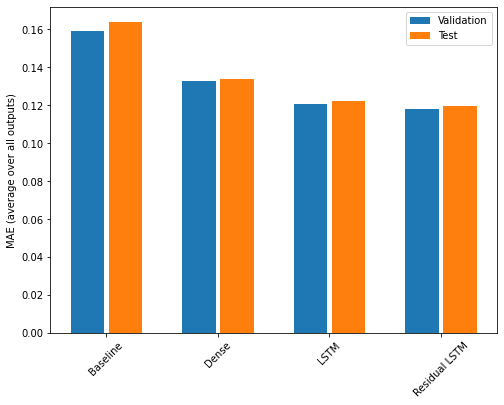

In [100]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

# 多步骤模型

在多步预测中，模型需要学习预测一系列未来值。因此，与仅预测单个未来点的单步模型不同，多步模型预测未来值的序列。

有两种粗略的方法：

1. 一次预测整个时间序列的单次预测。
2. 自回归预测，其中模型仅进行单步预测，其输出作为输入反馈。



在本节中，所有模型都将预测**所有输出时间步的所有特征**。

对于多步模型，训练数据再次由每小时样本组成。然而，在这里，模型将学习预测未来 24 小时，假设过去 24 小时。

这是一个Window从数据集中生成这些切片的对象：

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

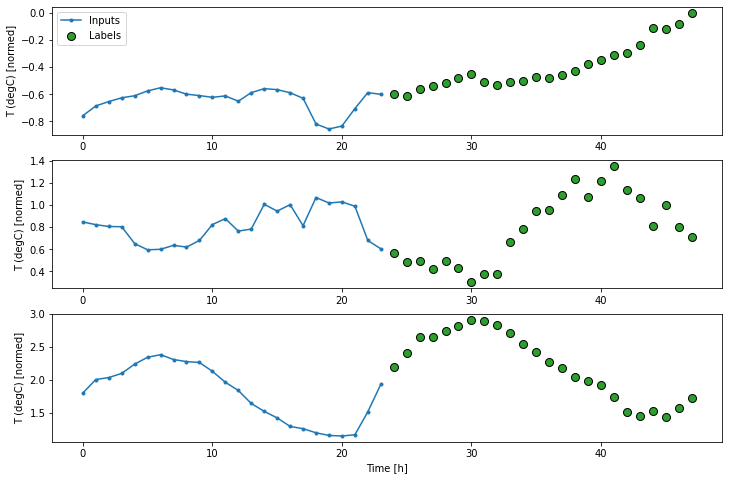

In [101]:
OUT_STEPS = 24
multi_window = WindowGenerator(
    input_width=24,
    label_width= OUT_STEPS,
    shift = OUT_STEPS
)
multi_window.plot()
multi_window

# 多步骤模型-基线
此任务的一个简单基线是针对所需的输出时间步数重复最后一个输入时间步

<img src='https://www.tensorflow.org/static/tutorials/structured_data/images/multistep_last.png'>

In [104]:
from pandas.core.indexes import multi
class MultiStepLastBaseline(tf.keras.Model):
  def call(self,inputs):
    return tf.tile(inputs[:,-1:,:],[1,OUT_STEPS,1])
  
last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.MeanAbsoluteError()])

437/437 [==============================] - 3s 6ms/step - loss: 0.6285 - mean_absolute_error: 0.5007


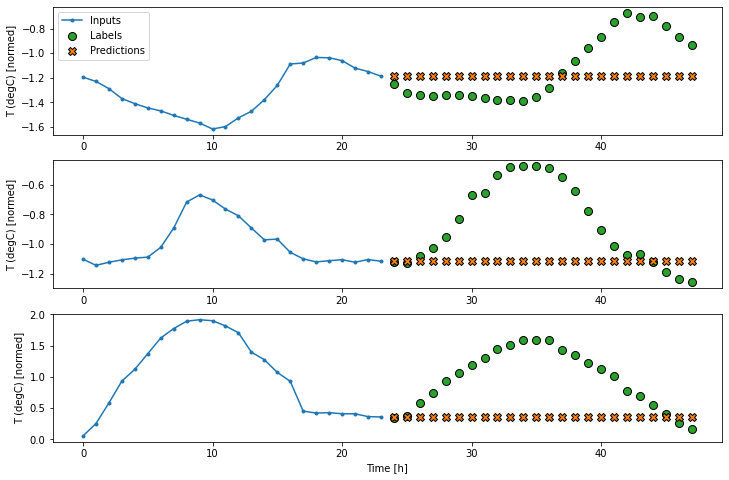

In [105]:
multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

由于此任务是预测未来 24 小时，给定过去 24 小时，另一个简单的方法是重复前一天，假设明天会相似：

<img src='https://www.tensorflow.org/static/tutorials/structured_data/images/multistep_repeat.png'>

437/437 [==============================] - 2s 5ms/step - loss: 0.4270 - mean_absolute_error: 0.3959


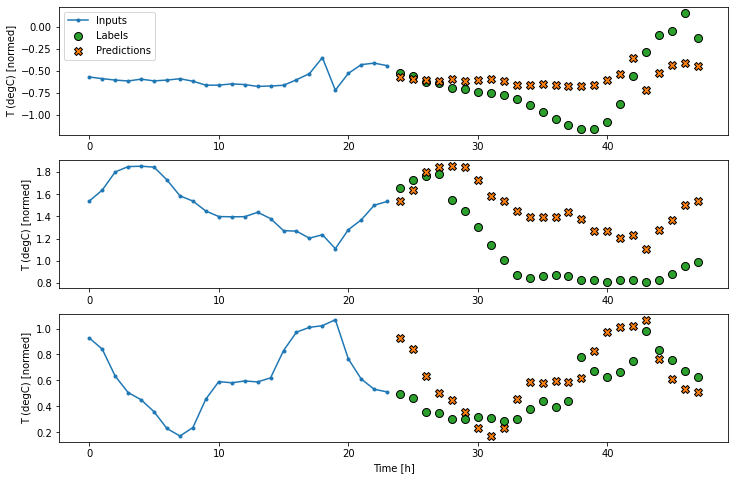

In [106]:
class RepeatBaseline(tf.keras.Model):
  def call(self,inputs):
    return inputs 
  
repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.MeanAbsoluteError()])



multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

# 多步骤模型-单发模型linear
决此问题的一种高级方法是使用“单次”模型，其中模型在一个步骤中进行整个序列预测。

这可以有效地实现为tf.keras.layers.Dense带有OUT_STEPS*features输出单元。该模型只需将该输出重塑为所需的(OUTPUT_STEPS, features).


**线形**
基于最后一个输入时间步长的简单线性模型比任何一个基线都好，但功率不足。该模型需要OUTPUT_STEPS从具有线性投影的单个输入时间步长预测时间步长。它只能捕获行为的低维切片，可能主要基于一天中的时间和一年中的时间。
<img src='https://www.tensorflow.org/static/tutorials/structured_data/images/multistep_dense.png'>

In [109]:
multi_linear_model = tf.keras.Sequential([
    # 取得最后一个time-step
   # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])



437/437 [==============================] - 2s 5ms/step - loss: 0.2558 - mean_absolute_error: 0.3050


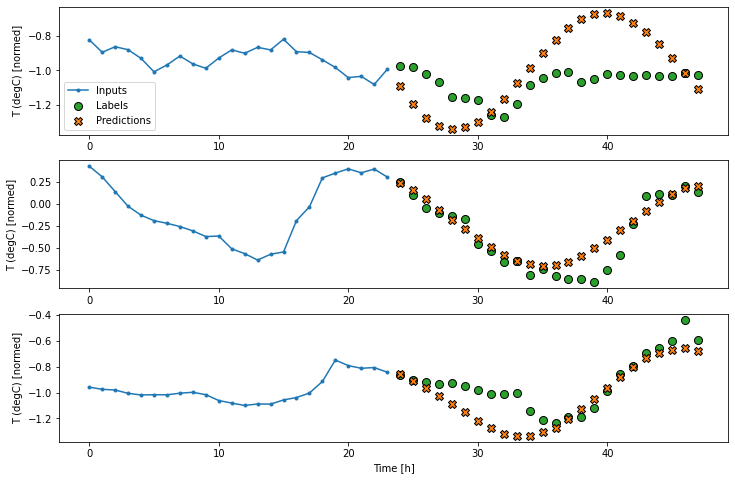

In [110]:
history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

# 多步骤模型-稠密dense

在输入和输出之间添加 atf.keras.layers.Dense可以使线性模型更强大，但仍然仅基于单个输入时间步长。




In [111]:
multi_dense_model = tf.keras.Sequential([
    # 取最后的时间阶段
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

437/437 [==============================] - 4s 9ms/step - loss: 0.2196 - mean_absolute_error: 0.2819


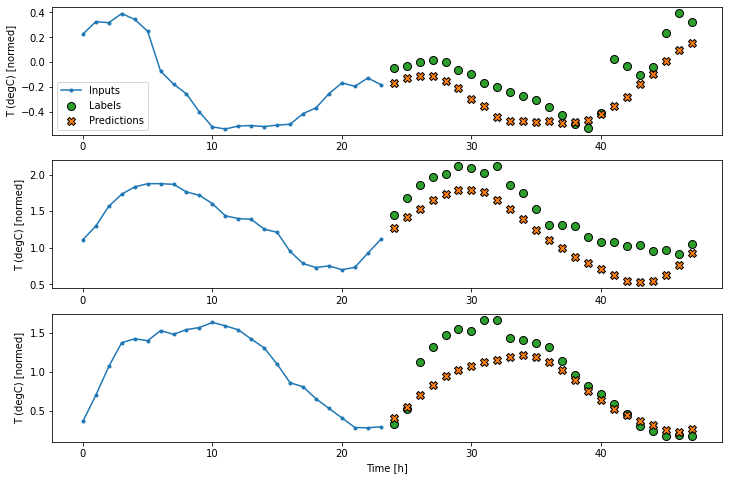

In [112]:
history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

# 多步骤模型-cnn

卷积模型基于固定宽度历史进行预测，这可能导致比密集模型更好的性能，因为它可以看到随着时间的变化：
<img src='https://www.tensorflow.org/static/tutorials/structured_data/images/multistep_conv.png'>



In [113]:
CONV_WIDTH = 3 
multi_conv_model = tf.keras.Sequential([
    # shape[batch,time,features]=>[batch,conv_width,features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # shape=>[batch,1,conv_units]
    tf.keras.layers.Conv1D(256,activation='relu',kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features]) 
])

437/437 [==============================] - 2s 5ms/step - loss: 0.2130 - mean_absolute_error: 0.2791


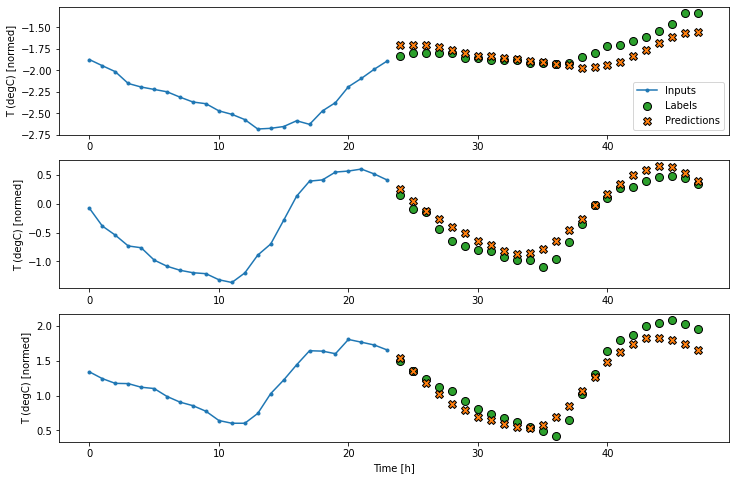

In [114]:
history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

# 多步骤模型-rnn
循环模型可以学习使用输入的长期历史，如果它与模型正在进行的预测相关。这里，模型将累积24小时的内部状态，然后对下一个24小时进行单个预测。
在这种单触发格式中，LSTM只需要在最后一个时间步产生输出，因此在tf.keras.layers.LSTM中设置return_sequences=False。
<img src='https://www.tensorflow.org/static/tutorials/structured_data/images/multistep_lstm.png'>

In [115]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])



437/437 [==============================] - 3s 7ms/step - loss: 0.2148 - mean_absolute_error: 0.2849


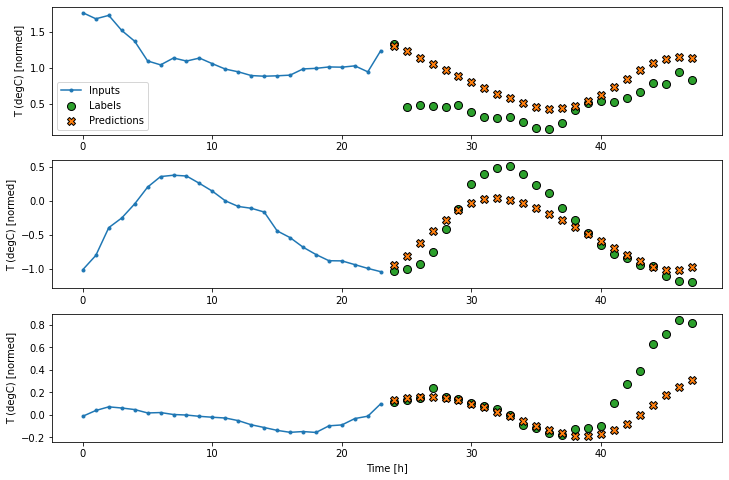

In [116]:
history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

# 多步骤模型-自回归模型
上述模型都在单个步骤中预测整个输出序列。
在某些情况下，模型将该预测分解为单独的时间步长可能会有所帮助。然后，每个模型的输出可以在每一步反馈到自身，并且可以在前一步的基础上进行预测，就像使用递归神经网络的经典生成序列一样。
这种类型的模型的一个明显优点是，它可以设置为产生不同长度的输出。
您可以使用本教程上半部分中训练的任何单步多输出模型，并在自回归反馈循环中运行，但这里您将重点构建一个经过明确训练的模型。
<img src ='https://www.tensorflow.org/static/tutorials/structured_data/images/multistep_autoregressive.png'>

构建一个自回归的RNN模型，应用于任何旨在输出单个时间步长的模型

模型必须手动管理每个步骤的输入，因此它tf.keras.layers.LSTMCell直接用于较低级别的单时间步接口。

In [117]:
class FeedBack(tf.keras.Model):
  def __init__(self,units,out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units= units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    #还将LSTMCell包装在RNN中，以简化“预热”方法。 
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell,return_state=True) 
    self.dense = tf.keras.layers.Dense(num_features)

In [118]:
 feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)
 
 

In [119]:
def warmup(self,inputs):
  # 此方法返回单个时间步长预测和 的内部状态LSTM：


  # inputs.shape => (batch,time,features)
  # x.shape -> (batch,lstm_units)
  x,*state = self.lstm_rnn(inputs)

  # predictions.shape => (batch,features)
  prediction = self.dense(x)
  return prediction,state 

FeedBack.warmup = warmup

In [120]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 19])

In [126]:
def call(self,inputs,training=None):
  # 使用TensorArray去捕获动态输出
  predictions = []
  # 初始化lstm状态
  prediction,state= self.warmup(inputs)

  # 输入第一个预测
  predictions.append(prediction)

  # 跑剩下的预测
  for n in range(1,self.out_steps):
    # 使用最后的预测作为输入
    x = prediction

    # 执行lstm step
    x,state = self.lstm_cell(x,states=state,training=training)

    # 转换lstm输出去预测
    prediction = self.dense(x)
    # 增加预测去到输出
    predictions.append(prediction)

  # 预测的shape=>(time,batch,features)
  predictions = tf.stack(predictions)
  # 预测.shape =>(hatch,time,features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions
FeedBack.call = call

In [127]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 19)


437/437 [==============================] - 4s 10ms/step - loss: 0.2294 - mean_absolute_error: 0.3030


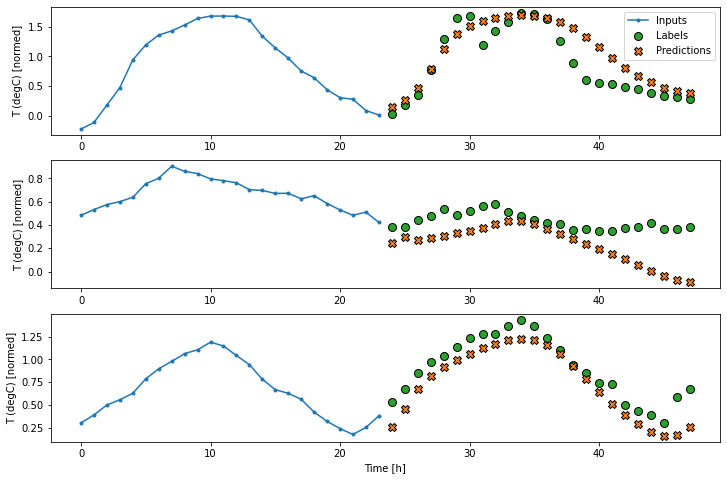

In [128]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

# 多步骤模型-表现综合

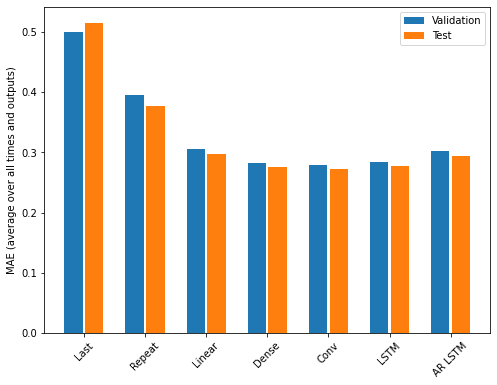

In [129]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [130]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.5157
Repeat  : 0.3774
Linear  : 0.2977
Dense   : 0.2752
Conv    : 0.2726
LSTM    : 0.2778
AR LSTM : 0.2946
